In [233]:
#The basics
import pandas as pd
import numpy as np
import json

#Plotting
import matplotlib.pyplot as plt
import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf




In [380]:
#Load Data
with open('Wyscout/events/events_England.json') as f:
    eventsData = json.load(f)
eventsDf = pd.DataFrame(eventsData)

with open('Wyscout/players.json') as f:
    playersData = json.load(f)
playersDf = pd.DataFrame(playersData)

In [381]:
'''
we now filter by defenders, in the players dataframe, we have a json in one of the columns indicating
the different names of the players position, so we denormalize that column and then filter to get only the defenders
'''

#https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas/63311361#63311361

# normalize the column of dictionaries and join it to df
playersDf = playersDf.join(pd.json_normalize(playersDf.role))

# drop role column (optional)
#aux.drop(columns=['role'], inplace=True)

#Filter by player's position
playersDf = playersDf[playersDf['code2'] == 'DF']

In [382]:
#filter all the events to get only the defenders ones
def filterEventsByPlayers(eventsDf,playersDF):
    eventsDefenders = pd.DataFrame()
    for i,player in playersDF.iterrows():
        playerId = player['wyId']
        aux = eventsDf[eventsDf["playerId"] == playerId]
        eventsDefenders = eventsDefenders.append(aux)
    return eventsDefenders

In [383]:
eventsDefenders = filterEventsByPlayers(eventsDf,playersDf)

In [386]:
'''
create the chainID

chanID starts with 1, store teamId value

if teamId doesnt change, chainId is the same value
if teamID changes, check next teamID
    if return to previous teamID insert negative chanID
    if teamID is still diferent, increase chainID for this two events and increase chanId value
'''
#when using iterrows we shouldnt modify the object, so we create a copy
def createChainId(eventsDf):
    eventsDfWithChain = eventsDf

    chainId=1
    teamId = eventsDf.head(1)["teamId"].values[0]
    eventsDfWithChain["chainId"] = 0
    eventsDfWithChain["xg"] = None

    eventsDf['start'] = eventsDf.index
    eventsDf.start = eventsDf.start.shift(1, fill_value=eventsDf.index.min())


    for i,row in eventsDf.iterrows():
        aux = eventsDf.loc[row.start : i, ['teamId']]

        if (row["teamId"] == teamId):
            eventsDfWithChain.at[i,"chainId"] = chainId
        else:
            nextTeamId = aux["teamId"].values[1]
            if (nextTeamId == teamId):
                eventsDfWithChain.at[i,"chainId"] = -chainId
            else:
                chainId +=1
                teamId = nextTeamId
                eventsDfWithChain.at[i,"chainId"] = chainId
    return eventsDfWithChain

In [385]:
eventsDfWithChain = createChainId(eventsDf)

In [387]:
'''
now we can create and fit a model for the xg value
when done, we search all the goals within the chain, and add the xg to their chains
'''
def createShotsModel(eventsDfWithChain):
    #Create a data set of shots.
    trainDf = pd.DataFrame(eventsDfWithChain)
    pd.unique(trainDf['subEventName'])
    shotsDf=trainDf[trainDf['subEventName']=='Shot']
    shotsModel=pd.DataFrame(columns=['Goal','X','Y'])

    #Go through the dataframe and calculate X, Y co-ordinates.
    #Distance from a line in the centre
    #Shot angle.
    #Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events
    for i,shot in shotsDf.iterrows():
        
        header=0
        for shottags in shot['tags']:
            if shottags['id']==403:
                header=1
        #Only include non-headers        
        if not(header):        
            shotsModel.at[i,'X']=100-shot['positions'][0]['x']
            shotsModel.at[i,'Y']=shot['positions'][0]['y']
            shotsModel.at[i,'C']=abs(shot['positions'][0]['y']-50)
        
            #Distance in metres and shot angle in radians.
            x=shotsModel.at[i,'X']*105/100
            y=shotsModel.at[i,'C']*65/100
            shotsModel.at[i,'Distance']=np.sqrt(x**2 + y**2)
            a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
            if a<0:
                a=np.pi+a
            shotsModel.at[i,'Angle'] =a
        
            #Was it a goal
            shotsModel.at[i,'Goal']=0
            for shottags in shot['tags']:
                    #Tags contain that its a goal
                    if shottags['id']==101:
                        shotsModel.at[i,'Goal']=1
    return shotsModel

In [391]:
shotsModel = createShotsModel(eventsDfWithChain)

In [392]:
shotsModel.columns

Index(['Goal', 'X', 'Y', 'C', 'Distance', 'Angle'], dtype='object')

In [393]:
# List the model variables you want here
#model_variables = ['Angle','Distance','X','C']
modelVariables = ['Angle','Distance']
model=''
for v in modelVariables[:-1]:
    model = model  + v + ' + '
model = model + modelVariables[-1]

#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shotsModel, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7131
Model Family:                    Binomial   Df Model:                            2
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1990.9
Date:                    Tue, 28 Sep 2021   Deviance:                       3981.8
Time:                            12:45:00   Pearson chi2:                 9.02e+03
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [394]:
#Return xG value for more general model
def calculate_xG(sh):    
   bsum=b[0]
   for i,v in enumerate(modelVariables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum)) 
   return xG   

#Add an xG to my dataframe
xG=shotsModel.apply(calculate_xG, axis=1) 
shotsModel = shotsModel.assign(xG=xG)

In [395]:
shotsModel[shotsModel["xG"]>0.6]

,Goal,X,Y,C,Distance,Angle,xG
28238,1,3,48,2.0,3.407712,1.647974,0.708250
64562,1,3,49,1.0,3.216364,1.702334,0.727124
73232,0,2,48,2.0,2.469818,2.013921,0.813720
75404,1,2,45,5.0,3.869431,1.468571,0.645354
78774,1,3,54,4.0,4.084422,1.429201,0.627732
...,...,...,...,...,...,...,...
611773,1,1,51,1.0,1.234909,2.566990,0.912254
624075,0,2,48,2.0,2.469818,2.013921,0.813720
630696,1,3,52,2.0,3.407712,1.647974,0.708250
635573,0,4,48,2.0,4.396590,1.380115,0.604084


In [396]:
#sacamos todos los goles
goals = shotsModel[shotsModel["Goal"] == 1]

In [397]:
#recorremos todos los goles, y añadimos su XG a todos los elementos de la cadena a la que pertenezca
def addXg(goals,eventsDfWithChain):
    for i,goal in goals.iterrows():
        xg = goal["xG"]
        chainId = eventsDfWithChain.at[i,"chainId"]
        chainEvents = eventsDfWithChain[eventsDfWithChain["chainId"] == chainId]
        for j,event in chainEvents.iterrows():
            eventsDfWithChain.at[j,"xg"] = xg
    return eventsDfWithChain


In [398]:
eventsDfWithChain = addXg(goals, eventsDfWithChain)

In [399]:
eventsDfWithChain = eventsDfWithChain[["eventId", "playerId", "matchId", "teamId", "chainId", "xg"]]
eventsDFWithChain = eventsDfWithChain[eventsDfWithChain["xg"] > 0] 


In [400]:
eventsDFWithChain

,eventId,playerId,matchId,teamId,chainId,xg
42,8,49876,2499719,1609,23,0.136206
43,8,167145,2499719,1609,23,0.136206
44,8,120339,2499719,1609,23,0.136206
45,10,25413,2499719,1609,23,0.136206
46,9,8480,2499719,1631,23,0.136206
...,...,...,...,...,...,...
642257,10,41174,2500098,1633,273523,0.036498
642258,9,10131,2500098,1623,273523,0.036498
642747,10,14703,2500098,1633,273740,0.020895
642887,10,145692,2500098,1623,273805,0.566211


In [401]:
'''
now we will take the number of interceptions for each player and add it on the dataframe
'''
def filterInterceptionsEvents(eventsDefenders):
    interceptionsDf = pd.DataFrame()

    for i,event in eventsDefenders.iterrows():
        for tag in event['tags']:
            if tag['id'] == 1401:
                interceptionsDf = interceptionsDf.append(event)
    return interceptionsDf

In [402]:
interceptionsDf = filterInterceptionsEvents(eventsDefenders)

In [403]:
def getMetrics(eventsDFWithChain2,interceptionsDf):
    aux = eventsDFWithChain2.groupby("playerId")["xg"].sum()
    metricsDf = aux.to_frame()

    metricsDf["interceptions"] = 0
    interceptionsDf["self"] = 1
    aux = interceptionsDf.groupby("playerId")["self"].count()
    for i,player in aux.to_frame().iterrows():
        metricsDf.at[i,"interceptions"] = player["self"]
    metricsDf = metricsDf[metricsDf["interceptions"] > 0]
    return metricsDf

In [404]:
metricsDf = getMetrics(eventsDFWithChain,interceptionsDf)

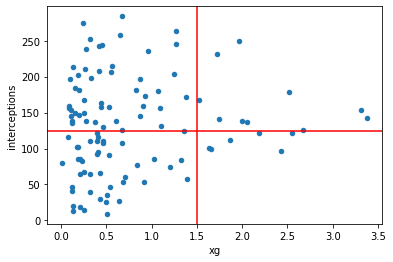

In [405]:
ax = metricsDf.plot.scatter(x="xg", y="interceptions")
ax.axvline(x=1.5,ymin=0, ymax=1, color="red")
ax.axhline(y=125, xmin=0, xmax=1, color="red")

In [406]:
def generateListOfPlayers(metricsDf,xgLimit,interceptionsLimit):
    aux = metricsDf[(metricsDf["xg"] > xgLimit) & (metricsDf["interceptions"] > interceptionsLimit)]
    listOfPlayers = aux.copy()
    listOfPlayers["firstName"] = None
    listOfPlayers["middleName"] = None
    listOfPlayers["lastName"] = None
    listOfPlayers["shortName"] = None

    for i,player in aux.iterrows():
        player = playersDf[playersDf["wyId"] == i]
        listOfPlayers.at[i,"firstName"] = player["firstName"].values[0]
        listOfPlayers.at[i,"middleName"] = player["middleName"].values[0]
        listOfPlayers.at[i,"lastName"] = player["lastName"].values[0]
        listOfPlayers.at[i,"shortName"] = player["shortName"].values[0]
    return listOfPlayers

In [407]:
listOfPlayers = generateListOfPlayers(metricsDf,1.5,125)

In [408]:
listOfPlayers

,xg,interceptions,firstName,middleName,lastName,shortName
playerId,,,,,,
7855,2.518076,179.0,Laurent,,Koscielny,L. Koscielny
7922,2.058901,137.0,Chris,,Smalling,C. Smalling
7939,1.998024,138.0,Ashley,,Young,A. Young
8277,2.668920,126.0,Kyle,,Walker,K. Walker
8336,1.960667,250.0,Kyle,,Naughton,K. Naughton
20612,1.521578,168.0,Shkodran,,Mustafi,S. Mustafi
25430,1.747525,141.0,Mamadou,,Sakho,M. Sakho
25553,1.717871,231.0,C\u00e9sar,,Azpilicueta Tanco,Azpilicueta
70086,3.376104,142.0,Nicol\u00e1s Hern\u00e1n,,Otamendi,N. Otamendi


In [232]:
playersDf[playersDf["wyId"] == 70086]

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId,code2,code3,name
430,"{'name': 'Argentina', 'id': '32', 'alpha3code'...",81,Nicol\u00e1s Hern\u00e1n,,Otamendi,1625,1988-02-12,183,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Argentina', 'id': '32', 'alpha3code'...",70086,right,N. Otamendi,12274,DF,DEF,Defender


In [ ]:
#########################################################
#######we do the same analysis in another league#########

In [409]:
#we do the same analysis in another league
with open('Wyscout/events/events_Spain.json') as f:
    eventsData = json.load(f)
eventsSpain = pd.DataFrame(eventsData)



In [410]:
SpainChain = createChainId(eventsSpain)

In [ ]:
shotsModelSpain = createShotsModel(SpainChain)
xG=shotsModelSpain.apply(calculate_xG, axis=1) 
shotsModelSpain = shotsModelSpain.assign(xG=xG)

In [310]:
shotsModelSpain[shotsModelSpain["xG"]>0.6]

,Goal,X,Y,C,Distance,Angle,xG
6579,1,2,45,5.0,3.869431,1.468571,0.645354
11552,1,3,52,2.0,3.407712,1.647974,0.708250
19460,1,3,54,4.0,4.084422,1.429201,0.627732
34214,1,3,52,2.0,3.407712,1.647974,0.708250
36718,1,2,53,3.0,2.865746,1.896003,0.781497
43554,1,3,54,4.0,4.084422,1.429201,0.627732
57572,1,2,50,0.0,2.100000,2.099773,0.836063
75294,0,3,48,2.0,3.407712,1.647974,0.708250
76588,0,4,48,2.0,4.396590,1.380115,0.604084
82922,1,4,52,2.0,4.396590,1.380115,0.604084


In [311]:
#sacamos todos los goles
goals = shotsModelSpain[shotsModelSpain["Goal"] == 1]

In [364]:
SpainChain = addXg(goals, SpainChain)
SpainChain = SpainChain[["eventId", "playerId", "matchId", "teamId", "chainId", "xg"]]
SpainChain2 = SpainChain[SpainChain["xg"] > 0] 



In [331]:
defendersEventsSpain = filterEventsByPlayers(eventsSpain,playersDf)

In [333]:
interceptionsSpain = filterInterceptionsEvents(defendersEventsSpain)

In [370]:
spainMetrics = getMetrics(SpainChain2,interceptionsSpain)

In [371]:
spainMetrics

,xg,interceptions
playerId,,
254,0.680818,191.0
3269,5.158795,168.0
3270,0.936669,111.0
3277,0.995376,162.0
3304,2.248873,91.0
...,...,...
405972,NaN,7.0
406460,NaN,10.0
470756,NaN,2.0


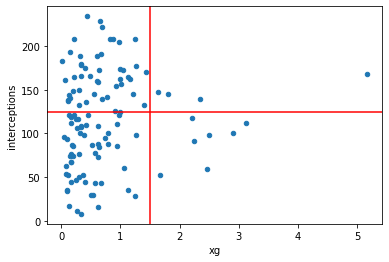

In [372]:
ax = spainMetrics.plot.scatter(x="xg", y="interceptions")
ax.axvline(x=1.5,ymin=0, ymax=1, color="red")
ax.axhline(y=125, xmin=0, xmax=1, color="red")

In [376]:
listOfPlayers = generateListOfPlayers(spainMetrics,1.5,125)

/tmp/ipykernel_18245/1243406245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listOfPlayers["firstName"] = None
/tmp/ipykernel_18245/1243406245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listOfPlayers["middleName"] = None
/tmp/ipykernel_18245/1243406245.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [377]:
listOfPlayers

,xg,interceptions,firstName,middleName,lastName,shortName
playerId,,,,,,
3269,5.158795,168.0,Jordi,,Alba Ramos,Jordi Alba
25397,2.351041,139.0,Samuel Yves,,Umtiti,S. Umtiti
70451,1.800827,145.0,Luis Carlos,,Correia Pinto,Luisinho
93003,1.637232,147.0,Dimitrios,,Siovas,D. Siovas
